In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import corner
import multiprocessing

In [2]:
M = 125 # GeV

def gen_bkg(N):
    return sp.stats.expon(loc=100, scale=1/0.05).rvs(N)

def gen_sig(N, m=M):
    return sp.stats.norm(loc=m, scale=2).rvs(N)

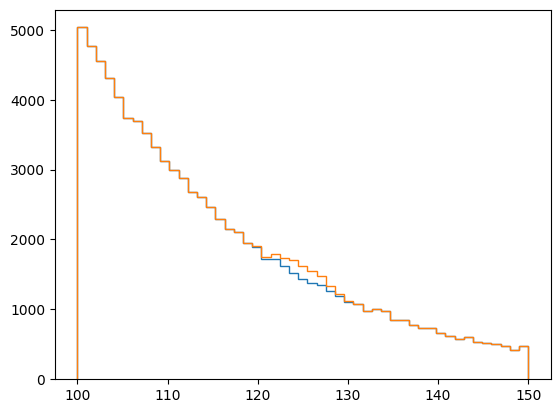

In [3]:
N_bkg = 100000
N_sig = 1000

mc_bkg = gen_bkg(N_bkg)
mc_sig = gen_sig(N_sig)

bins = np.linspace(100, 150, 50)

bkg_counts, bins = np.histogram(mc_bkg, bins=bins)
sig_counts, bins = np.histogram(mc_sig, bins=bins)

plt.stairs(bkg_counts, bins)
plt.stairs(sig_counts+bkg_counts, bins)


In [4]:
def nll(s, b, sig, bkg, data):
    '''
    -2*log(p(data|theta))
    '''
    return -2*np.sum(sp.stats.poisson.logpmf(data, s*sig+b*bkg))

def nlprior(m, b):
    '''
    -2*log(p(theta))
    '''
    ps = 0 if 0 <= m <= 5 else np.inf
    b_exp = 1
    sigma_b = 0.5
    pb = ((b-b_exp)/sigma_b)**2
    return ps+pb

def nlposterior(s, b, sig, bkg, data):
    '''
    -2*log(p(theta|data))
    '''
    return nll(s, b, sig, bkg, data) + nlprior(s, b)

In [5]:
data_bkg = gen_bkg(N_bkg)
data_sig = gen_sig(N_sig)

data_bkg_counts, bins = np.histogram(data_bkg, bins=bins)
data_sig_counts, bins = np.histogram(data_sig, bins=bins)

data_counts = data_bkg_counts+2*data_sig_counts

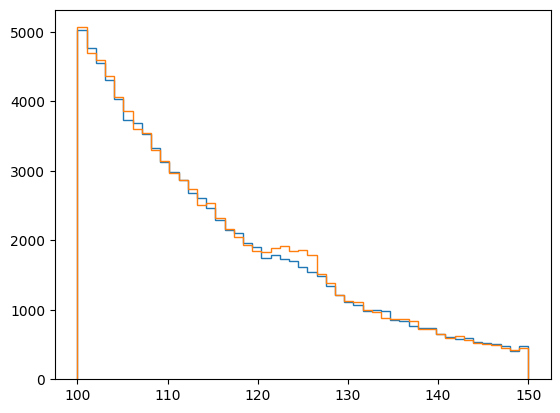

In [6]:
plt.stairs(sig_counts+bkg_counts, bins)
plt.stairs(data_counts, bins)

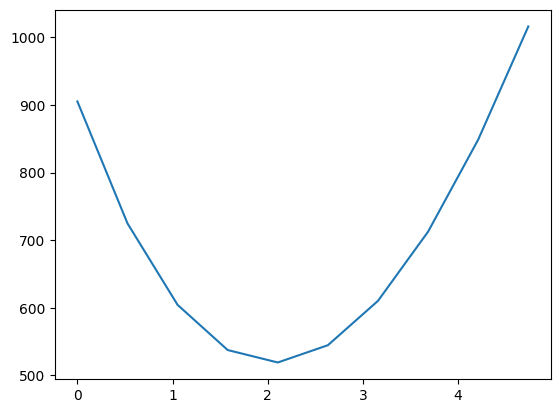

In [7]:
x = np.linspace(0,10, 20)
counts = sig_counts+bkg_counts
yerr = (sig_counts+bkg_counts)**0.5
post = lambda s, b: nlposterior(s, b, sig_counts, bkg_counts, data_counts)
yy=[post(xx, 1) for xx in x]

plt.plot(x,yy)

In [15]:
def metropolis_hastings(nlposterior, iterations, initial, proposal_std):
    samples = [initial]
    current = initial
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)
        
        # Compute acceptance ratio
        nlog_current = nlposterior(current)
        nlog_proposal = nlposterior(proposal)
        nlog_alpha = max(0, nlog_proposal - nlog_current)
        
        # Accept/reject step
        if -2*np.log(np.random.rand()) > nlog_alpha:
            current = proposal  # Accept proposal
        
        samples.append(current)
    
    return np.array(samples)

In [21]:
iterations = 1000000
initial = [1, 1]  # Starting values for [theta0, theta1]
chains = 16
proposal_std = [0.1, 0.1]  # Standard deviation of proposal distribution

nlpost = lambda pars: nlposterior(*pars, sig_counts, bkg_counts, data_counts)

# Random initial values for each chain
initial_points = [
    [np.random.uniform(0, 3), np.random.uniform(0, 3)] for _ in range(chains)
]

def run_chain(initial_point):
    chain = metropolis_hastings(nlpost, iterations, initial_point, proposal_std)
    return chain

# Using multiprocessing to run the chains in parallel
with multiprocessing.Pool(processes=chains) as pool:
    chains = pool.map(run_chain, initial_points)

# Combine all chains
all_samples = np.vstack(chains)


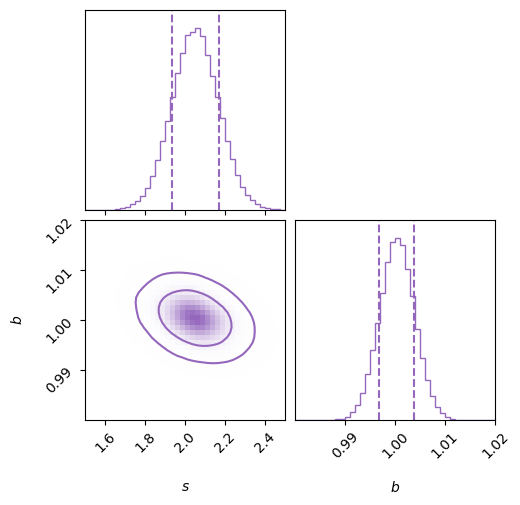

In [25]:
fig = corner.corner(
    all_samples,
    bins=40,
    range=[(1.5,2.5), (0.98,1.02)],
    levels=(0.68, 0.95),
    quantiles=(0.16, 0.84),
    smooth=1.0,
    plot_datapoints=False,
    labels=[r'$s$', r'$b$'],
    color='tab:purple',
    );

# file='plots/posterior.pdf'
# fig.savefig(file)

In [11]:
def pred(s):
    return np.array([s*30+50, s*10+70])

def likelihood(s, y):
    """Gaussian likelihood for linear model."""
    return np.exp(-0.5*(y-pred(s))**2/y).sum()

def prior(s):
    """Flat prior (constant for all beta)."""
    return 1 if 0 <= s <= 5 else 0

# Posterior density
def posterior(s, y):
    """Posterior density proportional to likelihood * prior."""
    return likelihood(s, y) * prior(s)

# Metropolis-Hastings Algorithm
def metropolis_hastings(iterations, initial, proposal_std, y):
    samples = [initial]
    current = initial
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=1)
        
        # Compute acceptance ratio
        p_current = posterior(current[0], y)
        p_proposal = posterior(proposal[0], y)
        alpha = min(1, p_proposal / p_current)
        
        
        # Accept/reject step
        if np.random.rand() < alpha:
            current = proposal  # Accept proposal
        
        samples.append(current)
    
    return np.array(samples)

# Parameters for MCMC
iterations = 100000
initial = [1]  # Starting values for [beta0, beta1]
proposal_std = [0.5]  # Standard deviation of proposal distribution

# Run Metropolis-Hastings
samples = metropolis_hastings(iterations, initial, proposal_std, pred(3))

In [12]:
def pred(x):
    s,b = x
    return np.array([s*30+b*50, s*10+b*70, b*10])

def nlog_likelihood(x, y):
    return np.sum((y-pred(x))**2/y)

def nlog_prior(x):
    s,b = x
    ps = 0 if 0 <= s <= 8 else np.inf
    mub, sigb = 1, 0.5
    pb = ((b-mub)/sigb)**2
    return ps+pb

def nlog_posterior(x, y):
    return nlog_likelihood(x, y) + nlog_prior(x)

# Metropolis-Hastings Algorithm
def metropolis_hastings(iterations, initial, proposal_std, y):
    samples = [initial]
    current = initial
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)
        
        # Compute acceptance ratio
        nlog_current = nlog_posterior(current, y)
        nlog_proposal = nlog_posterior(proposal, y)
        nlog_alpha = max(0, nlog_proposal - nlog_current)
        
        # Accept/reject step
        if -2*np.log(np.random.rand()) > nlog_alpha:
            current = proposal  # Accept proposal
        
        samples.append(current)
    
    return np.array(samples)

iterations = 100000
initial = [1,1]  
proposal_std = [0.1,0.1]

samples = metropolis_hastings(iterations, initial, proposal_std, pred([3,1.3]))

KeyboardInterrupt: 

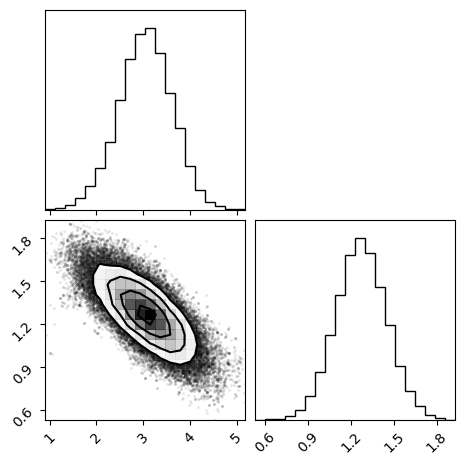

In [11]:
corner.corner(samples);

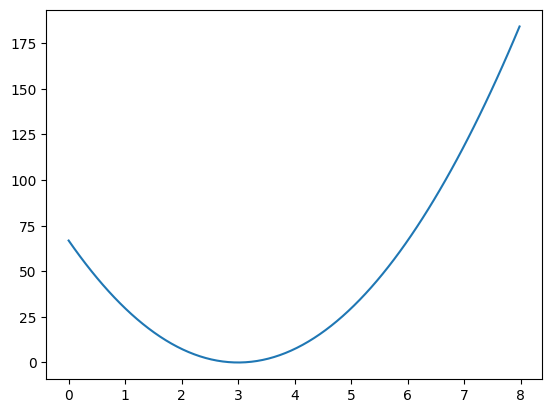

In [233]:
x=np.linspace(0,10,100)
plt.plot(x, [nlog_posterior([i, 1], pred([3,1])) for i in x])

In [234]:
def chi2(x, data):
    s,b=x
    return np.sum((data - pred(s,b))**2 / data)

dd = pred([3,1.1])
sp.optimize.minimize(nlog_posterior, x0=[1,1], args=(dd))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.4786857496304227e-12
        x: [ 3.000e+00  1.100e+00]
      nit: 5
      jac: [-3.084e-06  5.553e-06]
 hess_inv: [[ 1.574e-01 -3.689e-02]
            [-3.689e-02  1.558e-02]]
     nfev: 18
     njev: 6